# Microphone Fingerprinting

**[Project homepage.](https://github.com/victorazzam/mic)**

**[Project dataset.](https://www.kaggle.com/datasets/victorazzam/microphone-fingerprinting)**

---

**Main goal:** identify microphones by the sounds they recorded.

**Requirements:** audio files (WAV) and the following Python libraries:
 - librosa
 - matplotlib
 - numpy
 - pandas
 - pydub
 - scikit-learn

### Necessary Libraries

In [ ]:
!pip install pydub

In [2]:
# System
import os, sys, time, random, pickle, warnings, threading, traceback

# Audio
import wave, librosa
from pydub import AudioSegment
from pydub.silence import split_on_silence

# ML helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML classifiers
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

### Key Functions

#### Audio Trimming

For making audio files smaller and easier to work with. Feel free to remove this step if you have a 🥩beefy🥩 setup.

In [3]:
def trim_sound(input_file, output_file, start_minute, end_minute):
    with wave.open(input_file, 'rb') as wav_in:
        params = wav_in.getparams()
        start_frame = int(start_minute * 60 * wav_in.getframerate())
        end_frame = int(end_minute * 60 * wav_in.getframerate())
        frames_to_read = min(end_frame - start_frame, wav_in.getnframes() - start_frame)
        wav_in.setpos(start_frame)
        audio_data = wav_in.readframes(frames_to_read)
        with wave.open(output_file, 'wb') as wav_out:
            wav_out.setparams(params)
            wav_out.writeframes(audio_data)

#### Audio Splitting

Splitting audio files by silence.

In [4]:
def break_silence(input_file, output_folder, min_duration=1, silence_thresh=-70, keep_silence=100):
    audio = AudioSegment.from_wav(input_file)
    segments = split_on_silence(
        audio,
        min_silence_len = int(min_duration * 1000),
        silence_thresh = silence_thresh,
        keep_silence = keep_silence
    )
    for i, segment in enumerate(segments):
        output_file = os.path.join(output_folder, f'part-{i:03d}.wav')
        if not os.path.isdir(output_folder):
            os.makedirs(output_folder)
        segment.export(output_file, format='wav')

#### Data Preparation

Loading and labelling audio files.

In [5]:
def load_data(data_folder):
    X, y = [], []
    for mic_folder in os.listdir(data_folder):
        path = os.path.join(data_folder, mic_folder)
        if os.path.isdir(path):
            label = int(path.split('-')[-1])
            for mic_part in os.listdir(path):
                if mic_part.lower().endswith('.wav'):
                    X.append(os.path.join(path, mic_part))
                    y.append(label)
    return X, np.array(y)

#### Feature Engineering

Here we extract and combine 3 features:
 - MFCC - Mel-Frequency Cepstral Coefficients
 - ZCR - Zero-Cross Rate
 - RMS - Root-Mean-Square power

In [6]:
def extract_features(file):
    audio, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr)
    mfcc = np.mean(mfcc.T, axis=0)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    zcr = np.mean(zcr.T, axis=0)
    rms = librosa.feature.rms(y=audio)
    rms = np.mean(rms.T, axis=0)
    return np.concatenate((mfcc, zcr, rms), axis=0)

#### Confusion Matrix - Single

Plotting a single model's Confusion Matrix.

In [7]:
def draw_cm(cm, f1, saveas, model_name, actual):

    # Normalize confusion matrix
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create plot
    fig, ax = plt.subplots()
    img = ax.imshow(cm_normalised, interpolation='nearest', cmap=plt.cm.OrRd)
    ax.figure.colorbar(img, ax=ax)

    # Set labels and ticks
    num_classes = len(np.unique(actual))
    ax.set(xticks = np.arange(num_classes),
           yticks = np.arange(num_classes),
           xticklabels = [mics[i] for i in range(num_classes)],
           yticklabels = [mics[i] for i in range(num_classes)],
           title = f'Confusion Matrix: {model_name}\nF1-score: {f1}',
           ylabel = 'True label',
           xlabel = 'Predicted label')

    # Rotate tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=36, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for i in range(num_classes):
            for j in range(num_classes):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha='center', va='center', fontsize=9,
                        color=('black', 'white')[cm_normalised[i, j] > 0.5])

    plt.tight_layout()
    #plt.savefig(saveas, bbox_inches='tight')
    plt.show()

#### Confusion Matrix - Combined

Consolidating all models' Confusion Matrices into one.

In [8]:
def draw_all(matrices, actual):

    # Normalize the consolidated confusion matrix
    consolidated = np.sum(matrices, axis=0)
    consolidated = consolidated.astype('float') / consolidated.sum(axis=1)[:, np.newaxis]

    # Create the heatmap plot
    fig, ax = plt.subplots()
    img = ax.imshow(consolidated, interpolation='nearest', cmap=plt.cm.OrRd)
    ax.figure.colorbar(img, ax=ax)

    # Set labels and ticks
    num_classes = len(np.unique(actual))
    ax.set(xticks = np.arange(num_classes),
           yticks = np.arange(num_classes),
           xticklabels = [mics[i] for i in range(num_classes)],
           yticklabels = [mics[i] for i in range(num_classes)],
           title = 'Consolidated Confusion Matrix',
           ylabel = 'True label',
           xlabel = 'Predicted label')

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=36, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, format(consolidated[i, j], '.2f'),
                    ha='center', va='center', fontsize=9,
                    color='white' if consolidated[i, j] > np.max(consolidated) else 'black')

    plt.tight_layout()
    #plt.savefig('confusion-matrix.svg')
    plt.show()

### Main Function


#### Load configuration parameters

Normally they are stored in a `parameters.json` file. For ease of understanding, this notebook will show them here.

In [9]:
root_path = './'
sources = ['sounds']
destination = root_path + 'processed'
labelled = 'labelled.dat'
featureset = 'features.dat'

time_start = random.randint(0, 30)
time_end = time_start + 30
keep_silence = False
min_silence = 1.1
threshold = -55
test_size = 0.2
random_state = 42

mics = [
	'Shure SM7B',
	't.bone MB 7 Beta',
	'1st Neumann KM 184',
	'2nd Neumann KM 184',
	'RODE NT1-A'
]

#### Prepare audio data

Trim audio and split on silence. If necessary, create the folder where the processed audio files will go.

In [10]:
if not os.path.isdir(destination):
    os.makedirs(destination)

data_saved = os.listdir(destination) # Has the data been prepared (trimmed / split)?
labels_saved = os.path.isfile(labelled) # Has the data been labelled?

In [11]:
if data_saved and labels_saved:
    print('Loading saved labelled data')
    with open(labelled, 'rb') as f:
        data = pickle.load(f)
elif not data_saved:
    for source in sources:
        source = root_path + source
        for mic in os.listdir(source):
            if mic.endswith('.wav'):
                print(f'Processing {mic} from {source}')
                mic_in = os.path.join(source, mic)
                mic_out = os.path.join(destination, mic)
                trim_sound(mic_in, mic_out, start_minute=time_start, end_minute=time_end)
                mic_parts = mic_out.rsplit('.')[0]
                break_silence(mic_out, mic_parts, min_duration=min_silence, silence_thresh=threshold, keep_silence=keep_silence)

Load audio files (X) and labels (y).

In [12]:
if not labels_saved:
    X, y = load_data(destination)
    data = pd.DataFrame({'files': X, 'labels': y})
    print(data.head())

                            files  labels
0  ./processed/mic-3/part-003.wav       3
1  ./processed/mic-3/part-011.wav       3
2  ./processed/mic-3/part-008.wav       3
3  ./processed/mic-3/part-004.wav       3
4  ./processed/mic-3/part-001.wav       3


Save everything.

In [13]:
if not labels_saved:
    print('Saving labelled data')
    with open(labelled, 'wb') as f:
        pickle.dump(data, f)

Saving labelled data


#### Extract and pre-process features

In [14]:
if os.path.isfile(featureset):
    print('Loading saved features and labels')
    with open(featureset, 'rb') as f:
        data_ft = pickle.load(f)
else:
    # Extract
    print('Extracting features')
    data_ft = pd.DataFrame(map(extract_features, data.files))
    data_ft['labels'] = data.labels

    # Remove duplicates
    print('Cleaning features: removing duplicates, replacing null values, ...')
    data_ft.fillna(0, inplace=True)
    unique = data_ft.nunique()
    data_ft.drop(unique[unique==1].index, axis=1, inplace=True)
    data_ft.replace([np.inf, -np.inf], 0, inplace=True)

    # Disconnect labels
    X = data_ft.iloc[:, :-1]
    y = data_ft.labels

    # Normalise
    print('Normalising features')
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Apply PCA
    print('Applying PCA to features')
    pca = PCA(n_components=8, random_state=random_state)
    X = pca.fit_transform(X)

    # Save
    print('Saving pre-processed features and labels')
    with open(featureset, 'wb') as f:
        pickle.dump(X, f)

Extracting features
Cleaning features: removing duplicates, replacing null values, ...
Normalising features
Applying PCA to features
Saving pre-processed features and labels


#### Preview the dataset

In [15]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7
0,0.495002,-2.085528,-0.836877,0.414102,-1.710394,0.562078,-0.270148,0.336593
1,-4.275365,-0.021016,0.324978,-0.308779,-0.487726,-1.502965,-0.191613,-0.749029
2,-4.659454,-1.021305,-0.495019,-1.498965,0.079083,-1.289744,0.241853,-0.579301
3,2.314925,-3.142992,-0.907306,0.026829,0.144600,1.075491,-1.232117,-0.435531
4,0.922769,-2.991989,-0.334220,-0.285597,-1.096458,-0.255113,-0.692039,0.833068


#### Split into training and testing data sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

#### Prepare classifiers

In [17]:
models = {
        'svc.model':  SVC(random_state=random_state),
        'mlp.model':  MLPClassifier(random_state=random_state),
        'knn.model':  KNeighborsClassifier(n_neighbors=len(set(y))),
        'rf.model':   RandomForestClassifier(n_estimators=100, random_state=random_state),
        'gbc.model':  GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=random_state),
        'lr.model':   LogisticRegression(solver='lbfgs', random_state=random_state),
        'nb.model':   GaussianNB(),
        'dt.model':   DecisionTreeClassifier(random_state=random_state)
}
reports, matrices = None, []

#### Train models and output results

Training and saving model
SVC(random_state=42)


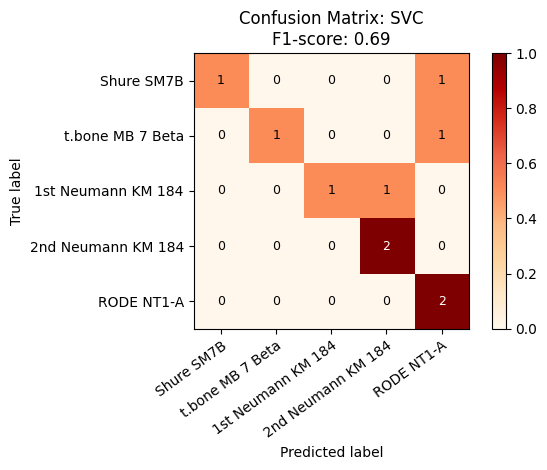

Training and saving model


MLPClassifier(random_state=42)


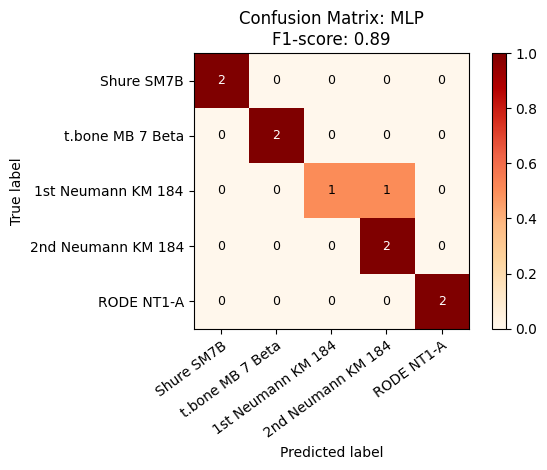

Training and saving model
KNeighborsClassifier()


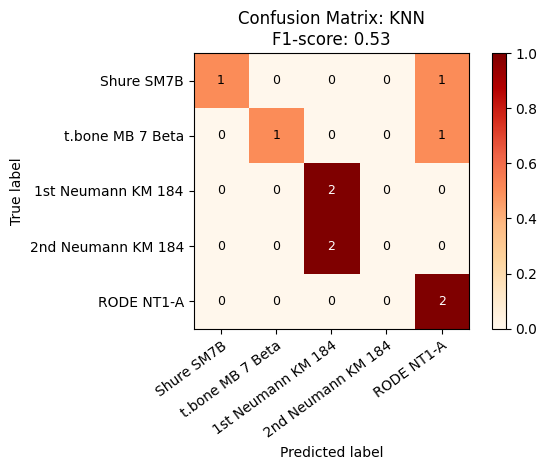

Training and saving model
RandomForestClassifier(random_state=42)


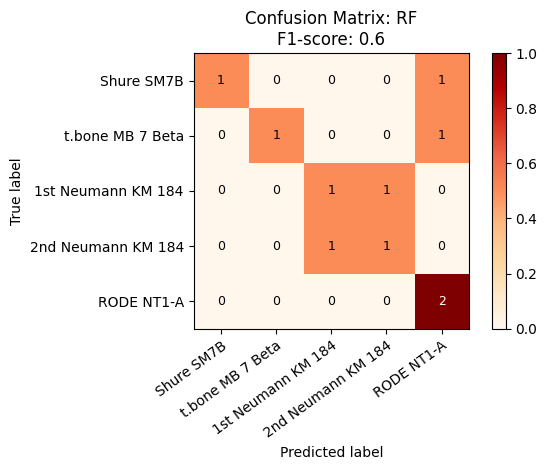

Training and saving model
GradientBoostingClassifier(random_state=42)


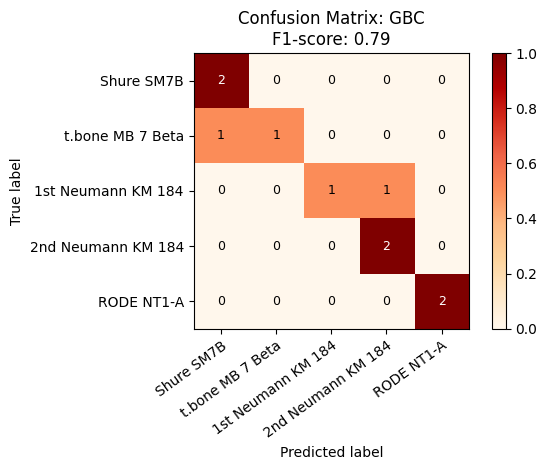

Training and saving model
LogisticRegression(random_state=42)


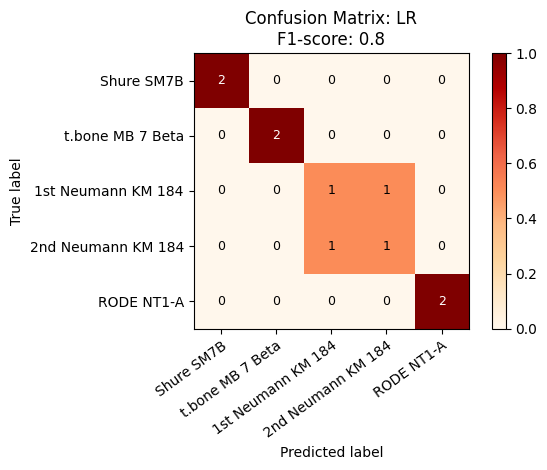

Training and saving model
GaussianNB()


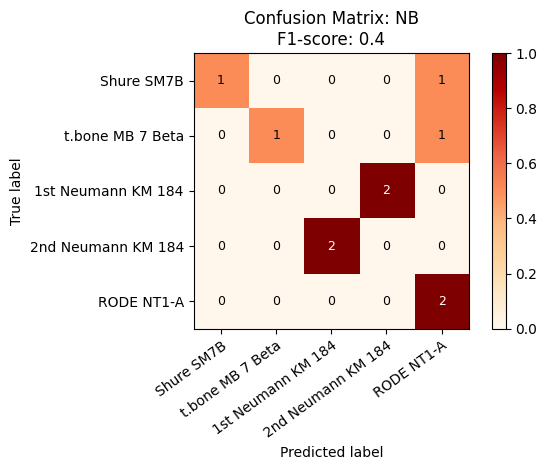

Training and saving model
DecisionTreeClassifier(random_state=42)


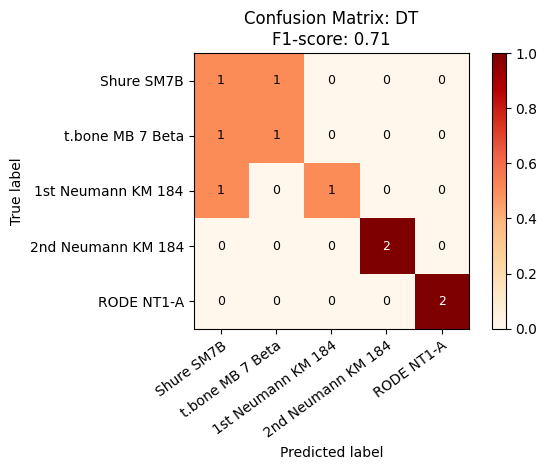

In [18]:
for model_name, model in models.items():
    if os.path.isfile(model_name):
        print('Loading saved model')
        with open(model_name, 'rb') as f:
            model = pickle.load(f)

    print('Training and saving model')
    model.fit(X_train, y_train)
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)

    # Model evaluation
    predictions = model.predict(X_test)
    actual = y_test
    model_ = model_name.split('.')[0]

    # Classification report
    print(model)
    report = classification_report(actual, predictions, target_names=mics, output_dict=True, zero_division=0)
    #print(f'Report:\n{report}')
    df_report = pd.DataFrame(report).transpose()
    reports = df_report if reports is None else reports.append(df_report)

    # Confusion matrix
    cm = confusion_matrix(actual, predictions)
    cm_f1 = round(report['weighted avg']['f1-score'], 2)
    cm_name = 'confusion-matrix-' + model_ + '.svg'
    draw_cm(cm, cm_f1, cm_name, model_.upper(), actual)
    matrices.append(cm)

#### Show combined Confusion Matrix

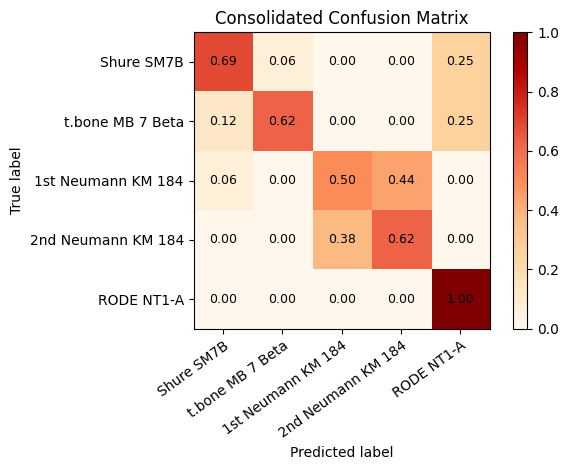

In [19]:
draw_all(matrices, actual)